### Carregando os arquivo para geração do modelo

In [1]:
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [72]:
# Carrega no Dataframe somente os dados que serão usados para treinar o modelo
df_csv = pd.read_csv('indicadores2-07-11.csv')[['id','vl_licitacao','indicador1','indicador2']]

In [73]:
# Visualizando algumas linhas iniciais dos dados carregados
df_csv[:5]

,id,vl_licitacao,indicador1,indicador2
0,3,7000.0,0.917143,1
1,4,300000.0,1.000010,1
2,5,44000.0,1.000000,0
3,6,18000.0,1.000000,0
4,7,46920.0,0.408696,0


In [75]:
# Buscando dados para cluster
df=df_csv[['vl_licitacao','indicador1','indicador2']]

In [76]:
#### Desativando o scaling dos dados
from sklearn import preprocessing

df=df_csv[['vl_licitacao','indicador1','indicador2']]
min_max_scaler = preprocessing.MinMaxScaler()
scaled_array = min_max_scaler.fit_transform(df.values.astype(float))
df_normalized = pd.DataFrame(scaled_array)
df_normalized[:5]

,0,1,2
0,0.000007,9.778759e-08,1.0
1,0.000300,1.066230e-07,1.0
2,0.000044,1.066220e-07,0.0
3,0.000018,1.066220e-07,0.0
4,0.000047,4.357597e-08,0.0


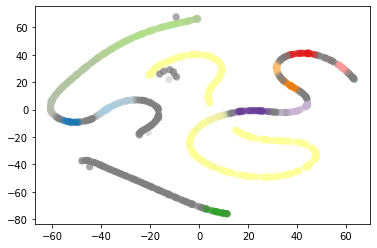

In [77]:
# Treinando o modelo
data = df_normalized.to_numpy()
clusterer = hdbscan.HDBSCAN(min_cluster_size=35, prediction_data=True).fit(data)

# Visualizando os dados após clusterização
from sklearn.manifold import TSNE
projection = TSNE().fit_transform(data)

color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [79]:
df_clusterized = pd.DataFrame({'Id': df_csv['id'] ,'Grupo': clusterer.labels_, 'Prob': clusterer.probabilities_})
df_clusterized.to_csv("clusterized.csv")
df_clusterized

,Id,Grupo,Prob
0,3,2,1.000000
1,4,0,0.674606
2,5,10,1.000000
3,6,10,1.000000
4,7,10,0.799410
...,...,...,...
2955,3097,-1,0.000000
2956,3098,10,1.000000
2957,3099,9,1.000000
2958,3100,-1,0.000000


### Salvando dados do modelo em arquivo
import pickle

with open('hdbscan-model.pkl', 'wb') as output:
    pickle.dump(clusterer, output, pickle.HIGHEST_PROTOCOL)

with open('hdbscan-projection_params.pkl', 'wb') as output:
    pickle.dump(data, output, pickle.HIGHEST_PROTOCOL)

with open('hdbscan-projection.pkl', 'wb') as output:
    pickle.dump(projection, output, pickle.HIGHEST_PROTOCOL)

## Código para forçar classificação dos sem grupo

soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[np.argmax(x)]
                  for x in soft_clusters]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

### Outliar Detection

data = np.load('clusterable_data.npy')
plt.scatter(*data.T, s=50, linewidth=0, c='b', alpha=0.25)

clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(data)
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

import pandas as pd
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
plt.scatter(*data.T, s=50, linewidth=0, c='gray', alpha=0.25)
plt.scatter(*data[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)